In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
import tensorflow as tf

Get the last 10 years of data to help with stock price prediction

In [2]:
start = '2014-01-01'
end = '2024-04-09'

stock = 'AAPL'
data = yf.download(stock, start, end)

[*********************100%%**********************]  1 of 1 completed


In [3]:
data.reset_index(inplace=True)
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-02,19.845715,19.893929,19.715000,19.754642,17.296654,234684800
1,2014-01-03,19.745001,19.775000,19.301071,19.320715,16.916721,392467600
2,2014-01-06,19.194643,19.528570,19.057142,19.426071,17.008966,412610800
3,2014-01-07,19.440001,19.498571,19.211430,19.287144,16.887329,317209200
4,2014-01-08,19.243214,19.484285,19.238930,19.409286,16.994274,258529600
...,...,...,...,...,...,...,...
2578,2024-04-02,169.080002,169.339996,168.229996,168.839996,168.839996,49329500
2579,2024-04-03,168.789993,170.679993,168.580002,169.649994,169.649994,47691700
2580,2024-04-04,170.289993,171.919998,168.820007,168.820007,168.820007,53704400
2581,2024-04-05,169.589996,170.389999,168.949997,169.580002,169.580002,42055200


# Moving Average Comparison

As a quantifier for the overall comparison of a stock price over time, a moving average will be used. First, we will compare to see how the moving average looks for multiple day ranges.

In [4]:
ma_100_days = data.Close.rolling(100).mean()

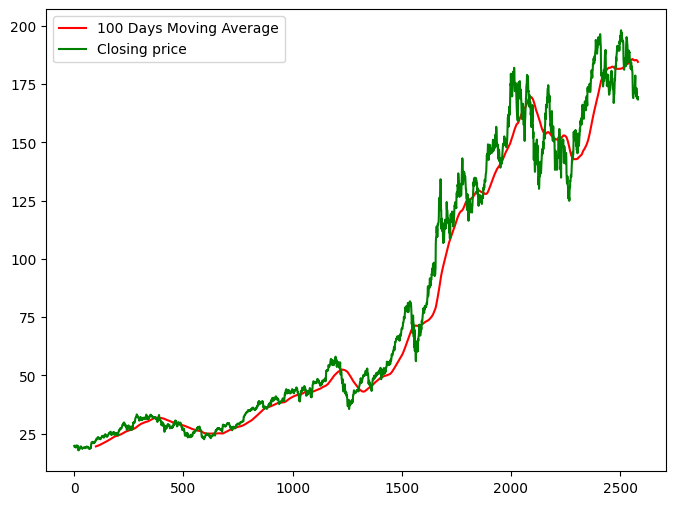

In [5]:
plt.figure(figsize = (8, 6))
plt.plot(ma_100_days, label = '100 Days Moving Average',color = 'r')
plt.plot(data.Close, label = 'Closing price', color = 'g')
plt.legend()

In [6]:
ma_200_days = data.Close.rolling(200).mean()

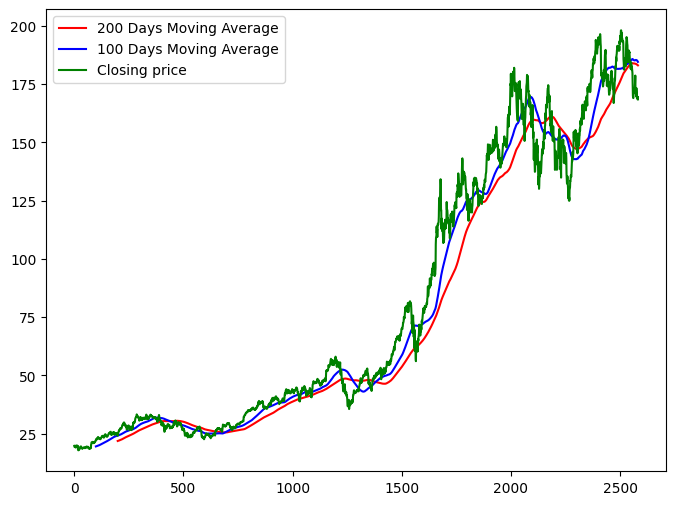

In [7]:
plt.figure(figsize = (8, 6))
plt.plot(ma_200_days, label = '200 Days Moving Average',color = 'r')
plt.plot(ma_100_days, label = '100 Days Moving Average', color = 'b')
plt.plot(data.Close, label = 'Closing price', color = 'g')
plt.legend()

In [8]:
data.dropna(inplace = True)

In [9]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-02,19.845715,19.893929,19.715000,19.754642,17.296654,234684800
1,2014-01-03,19.745001,19.775000,19.301071,19.320715,16.916721,392467600
2,2014-01-06,19.194643,19.528570,19.057142,19.426071,17.008966,412610800
3,2014-01-07,19.440001,19.498571,19.211430,19.287144,16.887329,317209200
4,2014-01-08,19.243214,19.484285,19.238930,19.409286,16.994274,258529600
...,...,...,...,...,...,...,...
2578,2024-04-02,169.080002,169.339996,168.229996,168.839996,168.839996,49329500
2579,2024-04-03,168.789993,170.679993,168.580002,169.649994,169.649994,47691700
2580,2024-04-04,170.289993,171.919998,168.820007,168.820007,168.820007,53704400
2581,2024-04-05,169.589996,170.389999,168.949997,169.580002,169.580002,42055200


# Training the LSTM Model

To train the data, we will split the dataset 80% for training and 20% for testing

In [10]:
data_train = pd.DataFrame(data.Close[0: int(len(data) * 0.80)])
data_test = pd.DataFrame(data.Close[int(len(data) * 0.80): len(data) - 1])

In [11]:
data_train.shape[0], data_test.shape[0]

(2066, 516)

In [12]:
scaler = MinMaxScaler(feature_range=(0,1))

In [13]:
data_train_scale = scaler.fit_transform(data_train)

In [14]:
average_day_timeframe = 100
x = []
y = []

for i in range(average_day_timeframe, data_train_scale.shape[0]):
    x.append(data_train_scale[i - average_day_timeframe: i])
    y.append(data_train_scale[i, 0])

In [15]:
x, y = np.array(x), np.array(y)

In [16]:
model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = ((x.shape[1], 1))))
model.add(Dropout(0.2))

model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units = 1))

/opt/anaconda3/envs/testenv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mean_squared_error')

In [20]:
model.fit(x, y, epochs = 30, batch_size = 32, verbose = 1)

Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - loss: 0.0496
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - loss: 0.0071
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - loss: 0.0057
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - loss: 0.0039
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - loss: 0.0035
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - loss: 0.0032
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - loss: 0.0037
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - loss: 0.0036
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - loss: 0.0036
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - loss: 0.0038
Epoch 11/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - loss: 0.0030
Epoch 12/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - loss: 0.0033
Epoch 13/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - loss: 0.0028
Epoch 14/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - loss: 0.0031
Epoch 15/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - lo

In [30]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 60)        │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 80)        │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 120)            │        96,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 536,285 (2.05 MB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 357,524 (1.36 MB)

# Testing the LSTM Model with Test Data

Now that the model has been trained on the training data, it's time to see hwo the model did with the separated testing data.

In [31]:
past_timeframe_days = data_train.tail(average_day_timeframe)
data_test = pd.concat([past_timeframe_days, data_test], ignore_index=True)
data_test

,Close
0,148.690002
1,148.639999
2,149.320007
3,148.850006
4,152.570007
...,...
711,170.029999
712,168.839996
713,169.649994
714,168.820007


In [32]:
data_test_scale = scaler.fit_transform(data_test)

In [33]:
x = []
y = []

for i in range(average_day_timeframe, data_test_scale.shape[0]):
    x.append(data_test_scale[i - average_day_timeframe: i])
    y.append(data_test_scale[i, 0])
x, y = np.array(x), np.array(y)

In [34]:
y_predict = model.predict(x)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


In [35]:
y_predict = y_predict / scaler.scale_

In [36]:
actual_y = y  / scaler.scale_
y_predict

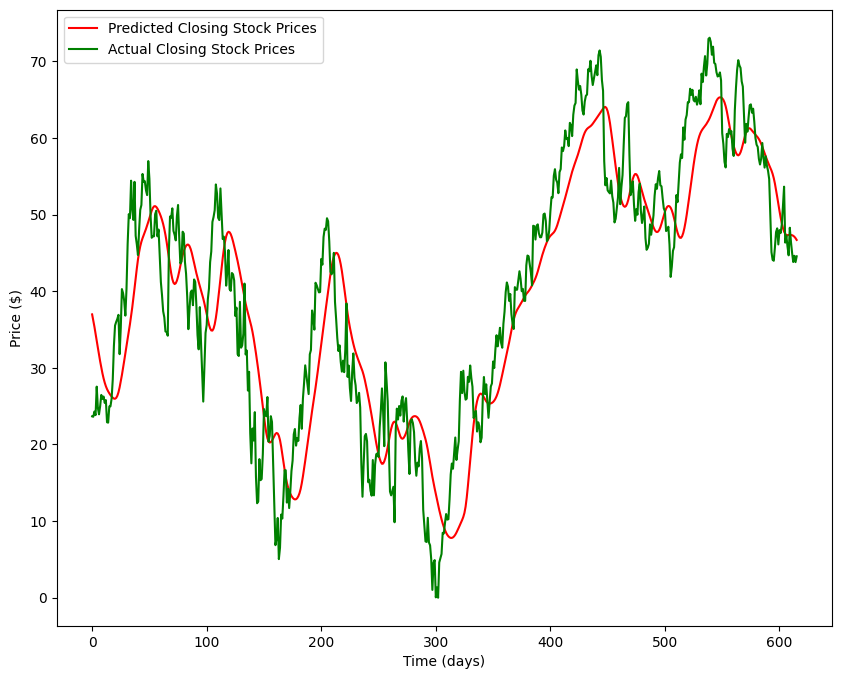

In [37]:
plt.figure(figsize = (10, 8))
plt.plot(y_predict, label = 'Predicted Closing Stock Prices', color = 'r')
plt.plot(actual_y, label = 'Actual Closing Stock Prices', color = 'g')
plt.xlabel("Time (days)")
plt.ylabel("Price ($)")
plt.legend()

In [38]:
model.save('Stock Prediction Model.keras')